<a href="https://colab.research.google.com/github/zelal-Eizaldeen/project2_Walmart_Price_Prediction/blob/main/Assignment_4_3113_zelalae2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Team Members**

Zilal Eiz Aldin (Online MCS) Zelalae2@illinois.edu

Mesay Taye (Online MCS) mesayst2@illinois.edu

Jianci Zhai (Online MCS) jianciz2@illinois.edu

# **Contribution of each member**

XXX By Mesay

XXX By Zilal

XXX By Jianci

# **Reference**

release: https://liangfgithub.github.io/Coding/F24_Coding4.pdf

https://campuswire.com/c/GB46E5679/feed/587

https://liangfgithub.github.io/Coding/F24_Coding4.pdf

question: https://campuswire.com/c/GB46E5679/feed/729

# **Setting**

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

# import all libraries
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import multivariate_normal

from matplotlib.colors import LogNorm

from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

# **Part I: Gaussian Mixtures**

reference:

https://liangfgithub.github.io/PSL/w7/w7_3_EM.html

https://campuswire.com/c/GB46E5679/feed/589 (hint)


In [3]:
data = pd.read_table('https://liangfgithub.github.io/Data/faithful.dat', sep="\s+", index_col=0)

Text(0, 0.5, 'Waiting')

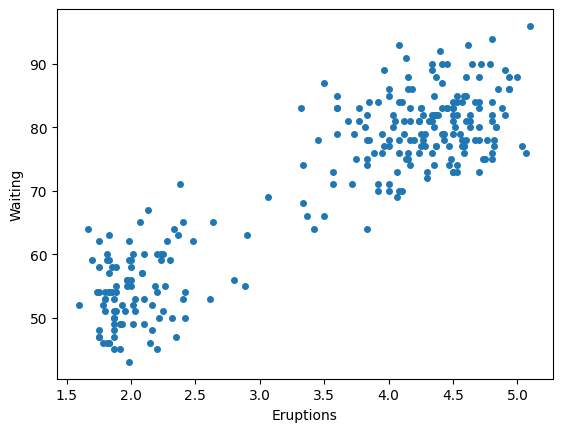

In [4]:
#create a pic for dataset
plt.scatter(data['eruptions'], data['waiting'], 16)
plt.xlabel('Eruptions')
plt.ylabel('Waiting')

In [5]:
data.head()

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85


# **Part1**

In [38]:
def myEM(data,G,itmax):
  #initilize dataset
  #sample size
  n=len(data)
  G=G
  xi_mtrx = np.reshape(np.array(data),(n,2))

  i_loop = 1
  print(f'-----------------------------------\n Iteration = {i_loop} \n')

  #initialize w_i_k (weight of probability of xi for group k)
  w_i_k = np.zeros((272, G))
  w_i_k[:10,0] = 1.0

  if G==2:
    w_i_k[10:,1] = 1.0
  else:
    w_i_k[10:30,1] = 1.0
    w_i_k[30:,2] = 1.0

  #initialize p_mtrx
  p_mtrx = w_i_k.sum(axis = 0)/n
  print(f'prob = {p_mtrx} \n')


  #initialize u for each group: https://campuswire.com/c/GB46E5679/feed/589
  #get the responsiblity for erp and wait for each xi based on the weight for each G
  erp_r = np.reshape(data['eruptions'],(n,1)) * w_i_k
  wait_r = np.reshape(data['waiting'],(n,1)) * w_i_k


  # checked
  erp_r_mean = erp_r.sum(axis=0)/ w_i_k.sum(axis=0)
  wait_r_mean = wait_r.sum(axis=0)/ w_i_k.sum(axis=0)
  r_mean = np.vstack((erp_r_mean, wait_r_mean))
  print(f'mean for each G is \n {r_mean}')

  #u_by_k is the the center each group G
  #dif_u_by_k is the difference from xi to the center each group G

  for p in range(0,G):
    dif_u_by_k_tmp = xi_mtrx - r_mean.T[p]

    if p == 0:
      dif_u_by_k = dif_u_by_k_tmp
    else:
      dif_u_by_k = np.concatenate((dif_u_by_k,dif_u_by_k_tmp),axis=1)

  sigma = sigma_cal(G,dif_u_by_k,w_i_k)
  w_i_k = Estep(G,sigma,dif_u_by_k,p_mtrx)



  while itmax+1 > i_loop:

    p_mtrx, dif_u_by_k, sigma = Mstep(G,w_i_k,data)
    w_i_k = Estep(G,sigma,dif_u_by_k,p_mtrx)

    i_loop = i_loop + 1
    print(f'-----------------------------------\n Iteration = {i_loop} \n')


In [39]:
'''calculate sigma and relevant metric
  the form provide by the instruction is BAD - consider sigma with with weight as well
  already know w_i_k (weight/responsibility)'''
def sigma_cal(G,dif_u_by_k,w_i_k):
  sigma_mtrx = np.zeros((n,4*G))
  for p in range(0,G):
    #shift in python is confusing
    #2 dim of sigma thinks sigma as [a,b] -> [a**2,ab,ab,b**2].reshape((2,2))
    #in addition need to apply weight

    sigma_mtrx[:, (4*p)] = dif_u_by_k[:,(2*p)]*dif_u_by_k[:,(2*p)]
    sigma_mtrx[:, (4*p+1)] = dif_u_by_k[:,(2*p)]*dif_u_by_k[:,(2*p+1)]
    sigma_mtrx[:, (4*p+2)] = dif_u_by_k[:,(2*p)]*dif_u_by_k[:,(2*p+1)]
    sigma_mtrx[:, (4*p+3)] = dif_u_by_k[:,(2*p+1)]*dif_u_by_k[:,(2*p+1)]


  weighted_sigma_mtrx = np.zeros((n,4*G))
  #apply weight from w_i_k
  for p in range(0,G):
    weighted_sigma_mtrx[:, (4*p):(4*(p+1))]=sigma_mtrx[:, (4*p):(4*(p+1))]*w_i_k[:,p].reshape((n,1))


  #fold a sigma
  sigma = (weighted_sigma_mtrx.sum(axis=0).reshape((G,4)).sum(axis=0)/n).reshape((2,2))
  #very close to very version i got use pd framework
  # sigma = [[  1.29793889  13.92641885]
  # [ 13.92641885 184.14381488]],

  print(f'sigma \n{sigma}')
  return sigma

In [40]:
def Estep(G,sigma,dif_u_by_k,p_mtrx):
  sigma_inv = np.linalg.inv(sigma)
  sigma_det = np.linalg.det(sigma)


  # create function to calculate the prob density function (xi-ug)t sigma_inv (xi-ug)
  # also: matrix = vector[a,b], sigma = array[[c,d],[d,e]]
  # matrix @ sigma @ matrix.T = a2⋅c+2⋅a⋅b⋅d+b2⋅e
  # i prob should name it pdf function

  sigma_inv_mtrx = np.zeros((n,G))

  for p in range(0,G):
    #in addition need to apply weight
    #python is confusion, p needs to shift -1 to map to corre colums

    sigma_inv_mtrx[:, p] = dif_u_by_k[:,(2*p)]*dif_u_by_k[:,(2*p)]*sigma_inv[0,0] + \
                                  2 * dif_u_by_k[:,(2*p)]*dif_u_by_k[:,(2*p+1)]*sigma_inv[0,1] +\
                                  dif_u_by_k[:,(2*p+1)]*dif_u_by_k[:,(2*p+1)]*sigma_inv[1,1]

  #apply weight from w_i_k
  #for p in range(1,G+1):
  #  sigma_inv_mtrx[:, p]=sigma_inv_mtrx[:, p]*w_i_k[:,p]


  #convert sigma_inv into pdf function
  #have p_mtrx to carry all p for each group
  pdf_mtrx = np.zeros((n,G))
  pdf_log_mtrx = np.zeros((n,G))
  for p in range(0,G):
    pdf_mtrx[:, p]=(p_mtrx[p]*np.exp(-0.5*sigma_inv_mtrx[:, p]))/(((2*np.pi)**2)*sigma_det)**0.5
    pdf_log_mtrx[:, p] = np.nan_to_num(np.log(pdf_mtrx[:, p]), neginf=0)


  loglik_output = loglik(pdf_mtrx)


  loglik_complete = pdf_log_mtrx.sum()
  loglik_complete

  w_i_k = pdf_mtrx/(pdf_mtrx.sum(axis = 1).reshape((n,1)))

  return w_i_k


In [41]:
def loglik(pdf_mtrx):
  loglik_output = np.log(np.array(pdf_mtrx.sum(axis = 1))).sum()
  print(f'loglik = {loglik_output}')
  return loglik_output

In [42]:
def Mstep(G,w_i_k,data):
  p_mtrx = w_i_k.sum(axis = 0)/n
  print(f'prob = {p_mtrx} \n')

  #get the responsiblity for erp and wait for each xi based on the weight for each G
  erp_r = np.reshape(data['eruptions'],(n,1)) * w_i_k
  wait_r = np.reshape(data['waiting'],(n,1)) * w_i_k

  # checked
  erp_r_mean = erp_r.sum(axis=0)/ w_i_k.sum(axis=0)
  wait_r_mean = wait_r.sum(axis=0)/ w_i_k.sum(axis=0)
  r_mean = np.vstack((erp_r_mean, wait_r_mean))
  print(f'mean for each G is \n {r_mean}')


  xi_mtrx = np.reshape(np.array(data),(n,2))
  #u_by_k is the the center each group G
  #dif_u_by_k is the difference from xi to the center each group G

  for p in range(0,G):
    dif_u_by_k_tmp = xi_mtrx - r_mean.T[p]

    if p == 0:
      dif_u_by_k = dif_u_by_k_tmp
    else:
      dif_u_by_k = np.concatenate((dif_u_by_k,dif_u_by_k_tmp),axis=1)

  sigma = sigma_cal(G,dif_u_by_k,w_i_k)


  return p_mtrx, dif_u_by_k, sigma

In [43]:
# initialize the data G=2
G=2 #group number
n = len(data) #length/row count/sample count of the data


In [44]:
myEM(data,2,20)

-----------------------------------
 Iteration = 1 

prob = [0.03676471 0.96323529] 

mean for each G is 
 [[ 3.3032      3.49482824]
 [71.8        70.86259542]]
sigma 
[[  1.29663847  13.93278021]
 [ 13.93278021 184.11269645]]
loglik = -1289.7693469979179
prob = [0.03685524 0.96314476] 

mean for each G is 
 [[ 3.31211483  3.49450513]
 [71.98706055 70.85534934]]
sigma 
[[  1.29675804  13.93374588]
 [ 13.93374588 184.09835147]]
loglik = -1289.7659495557787
-----------------------------------
 Iteration = 2 

prob = [0.03695665 0.96304335] 

mean for each G is 
 [[ 3.32141524  3.49416743]
 [72.18428601 70.84766166]]
sigma 
[[  1.29687674  13.93463695]
 [ 13.93463695 184.08022951]]
loglik = -1289.7620959265478
-----------------------------------
 Iteration = 3 

prob = [0.03707039 0.96292961] 

mean for each G is 
 [[ 3.33107607  3.49381592]
 [72.39169037 70.83951923]]
sigma 
[[  1.2969935   13.93543571]
 [ 13.93543571 184.05781438]]
loglik = -1289.7577343093897
-------------------------

In [13]:
#initialize w_i_k (weight of probability of xi for group k)
w_i_k = np.zeros((272, G))
w_i_k[:10,0] = 1.0

if G==2:
  w_i_k[10:,1] = 1.0
else:
  w_i_k[10:30,1] = 1.0
  w_i_k[30:,2] = 1.0

w_i_k.shape

(272, 2)

In [14]:
p_mtrx = w_i_k.sum(axis = 0)/n
p_mtrx

array([0.03676471, 0.96323529])

In [15]:
#initialize u for each group: https://campuswire.com/c/GB46E5679/feed/589
#get the responsiblity for erp and wait for each xi based on the weight for each G
erp_r = np.reshape(data['eruptions'],(n,1)) * w_i_k
wait_r = np.reshape(data['waiting'],(n,1)) * w_i_k

In [16]:
# checked
erp_r_mean = erp_r.sum(axis=0)/ w_i_k.sum(axis=0)
wait_r_mean = wait_r.sum(axis=0)/ w_i_k.sum(axis=0)
r_mean = np.vstack((erp_r_mean, wait_r_mean))
print(f'mean for each G is \n {r_mean}')

mean for each G is 
 [[ 3.3032      3.49482824]
 [71.8        70.86259542]]


In [17]:
xi_mtrx = np.reshape(np.array(data),(n,2))
#u_by_k is the the center each group G
#dif_u_by_k is the difference from xi to the center each group G

for p in range(0,G):
  dif_u_by_k_tmp = xi_mtrx - r_mean.T[p]

  if p == 0:
    dif_u_by_k = dif_u_by_k_tmp
  else:
    dif_u_by_k = np.concatenate((dif_u_by_k,dif_u_by_k_tmp),axis=1)

In [18]:
# calculate sigma
# the form provide by the instruction is BAD - consider sigma with with weight as well
# already know w_i_k (weight/responsibility)
sigma_mtrx = np.zeros((n,4*G))
for p in range(0,G):
  #shift in python is confusing
  #2 dim of sigma thinks sigma as [a,b] -> [a**2,ab,ab,b**2].reshape((2,2))
  #in addition need to apply weight

  sigma_mtrx[:, (4*p)] = dif_u_by_k[:,(2*p)]*dif_u_by_k[:,(2*p)]
  sigma_mtrx[:, (4*p+1)] = dif_u_by_k[:,(2*p)]*dif_u_by_k[:,(2*p+1)]
  sigma_mtrx[:, (4*p+2)] = dif_u_by_k[:,(2*p)]*dif_u_by_k[:,(2*p+1)]
  sigma_mtrx[:, (4*p+3)] = dif_u_by_k[:,(2*p+1)]*dif_u_by_k[:,(2*p+1)]



In [19]:
weighted_sigma_mtrx = np.zeros((n,4*G))
#apply weight from w_i_k
for p in range(0,G):
  weighted_sigma_mtrx[:, (4*p):(4*(p+1))]=sigma_mtrx[:, (4*p):(4*(p+1))]*w_i_k[:,p].reshape((n,1))



In [20]:
#fold a sigma
sigma = (weighted_sigma_mtrx.sum(axis=0).reshape((G,4)).sum(axis=0)/n).reshape((2,2))
 #very close to very version i got use pd framework
 # sigma = [[  1.29793889  13.92641885]
 # [ 13.92641885 184.14381488]],
print(f'sigma \n{sigma}')

sigma 
[[  1.29663847  13.93278021]
 [ 13.93278021 184.11269645]]


In [21]:
sigma_det = np.linalg.det(sigma)
sigma_det

44.60524138701267

In [22]:
sigma_inv = np.linalg.inv(sigma)
sigma_inv


array([[ 4.12760229, -0.31235747],
       [-0.31235747,  0.0290692 ]])

In [23]:
# create function to calculate the prob density function (xi-ug)t sigma_inv (xi-ug)
# also: matrix = vector[a,b], sigma = array[[c,d],[d,e]]
# matrix @ sigma @ matrix.T = a2⋅c+2⋅a⋅b⋅d+b2⋅e
# i prob should name it pdf function

sigma_inv_mtrx = np.zeros((n,G))

for p in range(0,G):
  #in addition need to apply weight
  #python is confusion, p needs to shift -1 to map to corre colums

  sigma_inv_mtrx[:, p] = dif_u_by_k[:,(2*p)]*dif_u_by_k[:,(2*p)]*sigma_inv[0,0] + \
                                2 * dif_u_by_k[:,(2*p)]*dif_u_by_k[:,(2*p+1)]*sigma_inv[0,1] +\
                                 dif_u_by_k[:,(2*p+1)]*dif_u_by_k[:,(2*p+1)]*sigma_inv[1,1]

#apply weight from w_i_k
#for p in range(1,G+1):
#  sigma_inv_mtrx[:, p]=sigma_inv_mtrx[:, p]*w_i_k[:,p]



In [24]:
#convert sigma_inv into pdf function
#have p_mtrx to carry all p for each group
pdf_mtrx = np.zeros((n,G))
pdf_log_mtrx = np.zeros((n,G))
for p in range(0,G):
  pdf_mtrx[:, p]=(p_mtrx[p]*np.exp(-0.5*sigma_inv_mtrx[:, p]))/(((2*np.pi)**2)*sigma_det)**0.5
  pdf_log_mtrx[:, p] = np.nan_to_num(np.log(pdf_mtrx[:, p]), neginf=0)

In [25]:
loglik = np.log(np.array(pdf_mtrx.sum(axis = 1))).sum()
loglik
print(f'loglik = {loglik}')

loglik = -1289.7693469979179


In [26]:
# initially will be the same
loglik_complete = pdf_log_mtrx.sum()
loglik_complete

-3524.8336908523875

In [27]:
pdf_mtrx.sum(axis = 1)

array([0.01186619, 0.00773701, 0.01691538, 0.01070829, 0.01380064,
       0.00576138, 0.01056542, 0.00215182, 0.00807877, 0.01267222,
       0.00815967, 0.00779203, 0.01943679, 0.00498499, 0.01331971,
       0.00878765, 0.00188761, 0.01206216, 0.00584146, 0.01896788,
       0.00755572, 0.00498499, 0.01050173, 0.0200435 , 0.00603425,
       0.00426152, 0.00969328, 0.02022078, 0.01940537, 0.01585006,
       0.00980778, 0.01241188, 0.01958553, 0.0181431 , 0.02254378,
       0.00896385, 0.00557538, 0.00785115, 0.00502822, 0.00840148,
       0.01781452, 0.00670537, 0.01464594, 0.00459466, 0.00470525,
       0.00143614, 0.0044843 , 0.0099171 , 0.01403664, 0.00794994,
       0.00290735, 0.00798848, 0.00815967, 0.00785115, 0.00685083,
       0.00996488, 0.02147349, 0.00066747, 0.00984011, 0.01782137,
       0.01246352, 0.01486237, 0.00571432, 0.01076632, 0.0039653 ,
       0.00271865, 0.01985418, 0.00815701, 0.00309631, 0.0024227 ,
       0.01419038, 0.0094363 , 0.01434062, 0.01411689, 0.00464

In [28]:
#Estep
w_i_k = pdf_mtrx/(pdf_mtrx.sum(axis = 1).reshape((n,1)))

In [29]:
p_mtrx = w_i_k.sum(axis = 0)/n
p_mtrx

array([0.03685524, 0.96314476])

In [30]:
#https://jaykmody.com/blog/distance-matrices-with-numpy/

In [31]:
X = np.array([[1,2]])
X_train = np.array([[3,4]])

In [32]:
x2 = np.sum(X**2, axis=1) # shape of (m)
y2 = np.sum(X_train**2, axis=1) # shape of (n)

xy = np.matmul(X, X_train.T)

x2 = x2.reshape(-1, 1)
dists = np.sqrt(x2 - 2*xy + y2) # (m, 1) repeat columnwise + (m, n) + (n) repeat rowwise -> (m, n)

In [33]:
dists

array([[2.82842712]])

In [34]:
for p in range(1,p+1):
  erp_col = 2*p
  wait_col = 2*p+2

  print(dif_u_by_k[:,erp_col:wait_col])

[[ 1.05171756e-01  8.13740458e+00]
 [-1.69482824e+00 -1.68625954e+01]
 [-1.61828244e-01  3.13740458e+00]
 [-1.21182824e+00 -8.86259542e+00]
 [ 1.03817176e+00  1.41374046e+01]
 [-6.11828244e-01 -1.58625954e+01]
 [ 1.20517176e+00  1.71374046e+01]
 [ 1.05171756e-01  1.41374046e+01]
 [-1.54482824e+00 -1.98625954e+01]
 [ 8.55171756e-01  1.41374046e+01]
 [-1.66182824e+00 -1.68625954e+01]
 [ 4.22171756e-01  1.31374046e+01]
 [ 7.05171756e-01  7.13740458e+00]
 [-1.74482824e+00 -2.38625954e+01]
 [ 1.20517176e+00  1.21374046e+01]
 [-1.32782824e+00 -1.88625954e+01]
 [-1.74482824e+00 -8.86259542e+00]
 [ 1.30517176e+00  1.31374046e+01]
 [-1.89482824e+00 -1.88625954e+01]
 [ 7.55171756e-01  8.13740458e+00]
 [-1.69482824e+00 -1.98625954e+01]
 [-1.74482824e+00 -2.38625954e+01]
 [-4.48282443e-02  7.13740458e+00]
 [-4.27828244e-01 -1.86259542e+00]
 [ 1.03817176e+00  3.13740458e+00]
 [ 1.05171756e-01  1.21374046e+01]
 [-1.52782824e+00 -1.58625954e+01]
 [ 5.88171756e-01  5.13740458e+00]
 [ 3.55171756e-01  7

In [35]:
tst = np.array([[  0.2968    ,   7.2  ],[ -1.5032    , -17.8 ]])

In [36]:
np.outer(tst,tst)

array([[ 8.80902400e-02,  2.13696000e+00, -4.46149760e-01,
        -5.28304000e+00],
       [ 2.13696000e+00,  5.18400000e+01, -1.08230400e+01,
        -1.28160000e+02],
       [-4.46149760e-01, -1.08230400e+01,  2.25961024e+00,
         2.67569600e+01],
       [-5.28304000e+00, -1.28160000e+02,  2.67569600e+01,
         3.16840000e+02]])

============================ CODE ARCHIVE ===================================

In [37]:
G_mtrx

NameError: name 'G_mtrx' is not defined

In [ ]:
  n=len(data)
  G=G

  G_mtrx, s_mtrx, p_mtrx, final_G,data_wg, mean_df= create_s_mtrx(G,n,s_interval=10)
  data_wg_cal = prep_data(G, G_mtrx, s_mtrx, p_mtrx, final_G,data_wg, mean_df)
  sigma, sigma_det = calc_sigma(data_wg_cal)
  w_i_k, loglik, loglik_complete  = Estep(G, data_wg_cal, sigma, p_mtrx)
  # report initial setting:
  print(f'initial setting: G= {final_G}, \n prob = {p_mtrx}, \n mean = \n{mean_df}, \n sigma = {sigma}, \n loglik = {loglik} \n ')
  i_loop = 1

  while itmax+1 > i_loop:


    p_mtrx, erup_mean, wait_mean, mean_df, s_mtrx = Mstep(G, data_wg_cal, sigma, w_i_k)
    #update dataset with output from Mstep
    data_wg = data_wg_cal[['eruptions', 'waiting', 'G', 'p']]
    #print(data_wg.columns.to_list())
    data_wg_cal = prep_data(G, G_mtrx, s_mtrx, p_mtrx, final_G,data_wg, mean_df)
    w_i_k, loglik, loglik_complete  = Estep(G, data_wg_cal, sigma,p_mtrx)
    print(f'--------------------------------------------------------------')
    print(f'iteration = {i_loop}: \n prob = {p_mtrx}, \n mean = \n{mean_df}, \n sigma = \n{sigma}, \n loglik = {loglik} \n')

    i_loop = i_loop + 1

In [ ]:
s_mtrx

In [ ]:
# https://liangfgithub.github.io/PSL/w7/w7_2_mixture.html
# Starting with an initial guess of our parameters, which encompass the means, variances, and mixing weight π of the Gaussians

p_mtrx

In [ ]:
data_wg

In [ ]:
data_mtrx = data[['eruptions','waiting']].to_numpy().reshape(-1,1)

In [ ]:
#create a copy of data for QA purpose
data_wg_cal = data_wg.copy()

In [ ]:
#get mean by G
mean_df

In [ ]:
mean_temp = mean_df.T
mean_temp

In [ ]:
p1 = mean_temp['p'].iloc[0]
p2 = mean_temp['p'].iloc[1]
try:
  p3 = mean_temp['p'].iloc[2]
except:
  print('no G = 3')

In [ ]:
mean_temp['ug'] = [np.array(row) for row in mean_temp[['eruptions','waiting']].to_numpy()]
mean_temp

In [ ]:
mean_temp['ug'].to_numpy()

In [ ]:
mean_mtrx_by_G = np.vstack(mean_temp['ug'].values)
mean_mtrx_by_G

In [ ]:
for i in range(0,final_G):
  print(mean_mtrx_by_G[i])

In [ ]:
mean_mtrx = np.array(mean_df)

In [ ]:

data_erp = data_wg_cal['eruptions'].to_numpy().reshape(-1,1) - mean_mtrx[0]#average eruptions time
data_erp = pd.DataFrame(data_erp)
data_erp.columns= ['erp_diff_'+ col for col in G_mtrx.astype('str').tolist()]

In [ ]:
data_erp

In [ ]:
data_wait = data_wg_cal['waiting'].to_numpy().reshape(-1,1) -mean_mtrx[1]#average waiting time
data_wait = pd.DataFrame(data_wait)
data_wait.columns= ['wait_diff_'+ col for col in G_mtrx.astype('str').tolist()]

In [ ]:
data_e_m = pd.DataFrame(mean_mtrx[0]).transpose()
data_e_m.columns= ['erp_'+ col for col in G_mtrx.astype('str').tolist()]

In [ ]:
data_w_m = pd.DataFrame(mean_mtrx[1]).transpose()
data_w_m.columns= ['wait_'+ col for col in G_mtrx.astype('str').tolist()]

In [ ]:
data_p = pd.DataFrame(mean_mtrx[2]).transpose()
data_p.columns= ['p_'+ col for col in G_mtrx.astype('str').tolist()]

In [ ]:


data_wg_cal = data_wg_cal.merge(data_p, how='cross').merge(data_e_m,how='cross').merge(data_w_m,how='cross')
data_wg_cal = pd.concat([data_wg_cal,data_erp,data_wait],axis = 1)
data_wg_cal.head()

In [ ]:
data_wg_cal

In [ ]:
  erp_mean=(s_mtrx*mean_mtrx[0]).sum()/n
  data_wg_cal['erp_mean'] = erp_mean
  data_wg_cal['erp_diff']=data_wg_cal['eruptions']-data_wg_cal['erp_mean']
  wait_mean=(s_mtrx*mean_mtrx[1]).sum()/n
  data_wg_cal['wait_mean']= wait_mean
  data_wg_cal['wait_diff']=data_wg_cal['waiting']-data_wg_cal['wait_mean']


In [ ]:
  data_wg_cal['xi']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['eruptions','waiting']].to_numpy()]
  data_wg_cal['u']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['erp_mean','wait_mean']].to_numpy()]
  data_wg_cal['u_1']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['erp_1','wait_1']].to_numpy()]
  data_wg_cal['u_2']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['erp_2','wait_2']].to_numpy()]
  if G==3:
    data_wg_cal['u_3']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['erp_3','wait_3']].to_numpy()]

In [ ]:
data_wg_cal['xi_minus_u']= data_wg_cal['xi']-data_wg_cal['u']
data_wg_cal['xi_minus_u1']= data_wg_cal['xi']-data_wg_cal['u_1']
data_wg_cal['xi_minus_u2']= data_wg_cal['xi']-data_wg_cal['u_2']
try:
  data_wg_cal['xi_minus_u3']= data_wg_cal['xi']-data_wg_cal['u_3']
except:
  print('no G = 3')

In [ ]:
data_wg_cal['xi_minus_u_T']= ([np.reshape(np.array(row),(1,2)) for row in data_wg_cal['xi']-data_wg_cal['u']])
data_wg_cal['xi_minus_u1_T']= ([np.reshape(np.array(row),(1,2)) for row in data_wg_cal['xi']-data_wg_cal['u_1']])
data_wg_cal['xi_minus_u2_T']= ([np.reshape(np.array(row),(1,2)) for row in data_wg_cal['xi']-data_wg_cal['u_2']])
try:
  data_wg_cal['xi_minus_u3_T']= ([np.reshape(np.array(row),(1,2)) for row in data_wg_cal['xi']-data_wg_cal['u_3']])
except:
  print('no G = 3')

In [ ]:
data_wg_cal.head()

In [ ]:

 #CA4,instruction p2, after 'Testing'
sigma = (data_wg_cal['xi_minus_u']*data_wg_cal['xi_minus_u_T']).sum(axis = 0)/n
sigma

In [ ]:
# find determinant of sigma |sigma|
sigma_det = np.linalg.det(sigma)
sigma_det

In [ ]:
data_wg_cal['sigma_inv'] =  [(sigma**-1)]*n

In [ ]:
#create log term
# double check on the TA session @10/25/2024 with professor, and she allowed hard code G = 2 or 3
# the second half of the log term is the probability density function (pdf) for 2D normal distribution
# so this is basically calcating the sum of (probability * pdf), a.k.a: calculate the corresponding
# distribution of Zi
# the key term for prob density func pdf

pdf_1  = -0.5* np.array(data_wg_cal['xi_minus_u1_T'].to_list()) @ np.array(data_wg_cal['sigma_inv'].to_list()) @ np.array(data_wg_cal['xi_minus_u1'].to_list())
pdf_2  = -0.5* np.array(data_wg_cal['xi_minus_u2_T'].to_list()) @ np.array(data_wg_cal['sigma_inv'].to_list()) @ np.array(data_wg_cal['xi_minus_u2'].to_list())
try:
  pdf_3 = -0.5 * np.array(data_wg_cal['xi_minus_u3_T'].to_list()) @ np.array(data_wg_cal['sigma_inv'].to_list()) @ np.array(data_wg_cal['xi_minus_u3'].to_list())
except:
  print('no G==3')

In [ ]:
pdf_1.shape

In [ ]:
# this is the real pdf
pdf_1_processed = p1*np.exp(pdf_1)/(((2*np.pi)**2)*sigma_det)**0.5
pdf_2_processed = p2*np.exp(pdf_2)/(((2*np.pi)**2)*sigma_det)**0.5
try:
  pdf_3_processed = p3*np.exp(pdf_3)/(((2*np.pi)**2)*sigma_det)**0.5
except:
  print('no G==3')

In [ ]:
log_pdf_1_processed = np.log(pdf_1_processed)
log_pdf_2_processed = np.log(pdf_2_processed)
try:
  log_pdf_3_processed = np.log(pdf_3_processed)
except:
  print('no G==3')

In [ ]:
pdf_1_processed.shape
# n * little sigma

In [ ]:
pdf_1_processed[0]

E-Step
https://campuswire.com/c/GB46E5679/feed/589

In [ ]:
# Derivation 1:
# compute the Marginal likelihood function
# A marginal likelihood function (also known as the evidence in Bayesian statistics) is a probability function that represents the likelihood of
# observing data under a specific model

if G==2:
  loglik = np.log(pdf_1_processed+pdf_2_processed).sum(axis=0)
else:
  loglik = np.log(pdf_1_processed+pdf_2_processed+pdf_3_processed).sum(axis=0)

loglik = loglik.item() # change an array of shape (1,1) to 1 number,array([[-1552]]) -> 1522
loglik


In [ ]:
# Derivation 2:
# compute the complete likelihood function
# The complete likelihood (or complete-data likelihood) refers to the likelihood function that considers
# both observed and unobserved (latent) data in a probabilistic model.

try:
  loglik_complete = log_pdf_1_processed + log_pdf_2_processed + log_pdf_1_processed
except:
  loglik_complete = log_pdf_1_processed + log_pdf_2_processed

loglik_complete = loglik_complete.sum()
loglik_complete

In [ ]:
# Derivation 3:
# create a matrix of weight, representing the weight of observation x1 assigned to Group G
# Darin's answer on this post gives great explanation: https://campuswire.com/c/GB46E5679/feed/648

try:
  w_i_1 = pdf_1_processed / (pdf_1_processed + pdf_2_processed + pdf_3_processed)
  w_i_2 = pdf_2_processed / (pdf_1_processed + pdf_2_processed + pdf_3_processed)
  w_i_3 = pdf_3_processed / (pdf_1_processed + pdf_2_processed + pdf_3_processed)

except:
  w_i_1 = pdf_1_processed / (pdf_1_processed + pdf_2_processed)
  w_i_2 = pdf_2_processed / (pdf_1_processed + pdf_2_processed)

In [ ]:
w_i_1 = np.squeeze(w_i_1).reshape(n,1)
w_i_2 = np.squeeze(w_i_2).reshape(n,1)

try:
  w_i_3 = np.squeeze(w_i_3).reshape(n,1)
except:
  print('no G==3')

In [ ]:
# output for Estep
try:
  w_i_k = np.hstack((w_i_1,w_i_2,w_i_3))
except:
  w_i_k = np.hstack((w_i_1,w_i_2))

In [ ]:
(np.array(data_wg_cal['eruptions'].to_list()).reshape((n,1))*w_i_k).sum(axis = 0)/w_i_k.sum(axis = 0)

In [ ]:
w_i_k.sum() # return n * 100% = 272

In [ ]:
# Derivation 3:
# create a matrix of weight, representing the weight of observation x1 assigned to Group G
# Darin's answer on this post gives great explanation: https://campuswire.com/c/GB46E5679/feed/648
# Mstep - maximize the probability of P given the observation
w_i_k.sum(axis = 0)/n
# iter 0-  array([0.03676471, 0.07352941, 0.88970588])

In [ ]:
w_i_k.sum(axis = 0)

In [ ]:
p_mtrx_new = w_i_k.sum(axis = 0)/n

In [ ]:
p1_new = p_mtrx_new[0]
p2_new = p_mtrx_new[1]
p3_new = p_mtrx_new[2]

In [ ]:
#initial mean
mean_mtrx_by_G

In [ ]:
erup_mean_tmp = (np.array(data_wg_cal['eruptions'].to_list()).reshape((n,1))*w_i_k).sum(axis = 0)
wait_mean_tmp = (np.array(data_wg_cal['waiting'].to_list()).reshape((n,1))*w_i_k).sum(axis = 0)

In [ ]:
erup_mean_tmp

Estep function: This function should return an n-by-G matrix, where the (i, j)th entry represents the
conditional probability P(Zi = k | xi). Here i ranges from 1 to n and k ranges from 1 to G.


Mstep function: This function should return the updated parameters for the Gaussian mixture model.


loglik function: This function computes the log-likelihood of the data given the parameters.

myEM function (main function): Inside this function, you can call the Estep and Mstep functions. The
function should take the following inputs and return the estimated parameters and log-likelihood (via
the loglik function)

# **Part II: HMM**

Baum-Welch Algorihtm

Viterbi Algorihtm

# **================ CODE ARCHIVE ================================**

In [ ]:
# TEST PANDA WITH MATRIX
matrix_1 = pd.DataFrame([[1, 2], [3, 4]])

In [ ]:
matrix_1

In [ ]:
# TEST PANDA WITH MATRIX
matrix_2 = pd.DataFrame([[[1,2],[3, 4]], [[5, 6],[7,8]]])

In [ ]:
matrix_2

In [ ]:
matrix_3 = pd.DataFrame([[np.zeros((2,3))], [np.zeros((3,2))]])
matrix_3

In [ ]:
data_wg_cal.head()

In [ ]:
data_wg_cal['x_i']= [np.array(row) for row in data_wg_cal[['eruptions','waiting']].to_numpy()]

In [ ]:
data_wg_cal['u_g']= [np.array(row) for row in data_wg_cal[['erp_mean','wait_mean']].to_numpy()]

In [ ]:
data_wg_cal

In [ ]:
data_wg_cal['x_i'] - data_wg_cal['u_g']

In [ ]:

#silly way to calculate sigma - result match
# [a,b] * [a,b].T is bascially a^2 +ab+ab+ b^2
#data_wg_cal[['eruptions_2',	'waiting_2']] = data_wg_cal[[	'eruptions',	'waiting']]**2
#data_wg_cal[['erp_mean_2',	'wait_mean_2']] = data_wg_cal[[	'erp_mean',	'wait_mean']]**2
#data_wg_cal['eruptions_erp_mean'] = data_wg_cal['eruptions']*data_wg_cal['erp_mean']
#data_wg_cal['waiting_wait_mean'] = data_wg_cal['waiting']*data_wg_cal['wait_mean']
data_wg_cal[['erp_diff_2',	'wait_diff_2']]  = data_wg_cal[[	'erp_diff',	'wait_diff']]**2
data_wg_cal['erp_wait_diff']  = data_wg_cal['erp_diff']*data_wg_cal['wait_diff']
data_wg_cal['erp_wait_diff_again']  = data_wg_cal['erp_diff']*data_wg_cal['wait_diff']

#CA4,instruction p2, after 'Testing'
sigma = np.array(data_wg_cal[['erp_diff_2','erp_wait_diff','erp_wait_diff_again','wait_diff_2']].mean()).reshape(2,2)
sigma

In [ ]:
#manually check the determinant function
#det(A)=ad−bc
sigma_det = sigma[0,0]*sigma[1,1]-sigma[0,1]*sigma[1,0]
sigma_det